# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
#!export CUDA_LAUNCH_BLOCKING=1
# !pip install torch
!pip install torchvision
!pip install transformers
#!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
!pip install mecab-python3
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
import gzip
import shutil
import sqlite3
import random
from math import ceil
import re
import csv
import glob
import torchvision
import statistics
import numpy as np
import lightgbm
import pickle
import statistics
import MeCab
import re
import copy

import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# PyTorchとGPU設定

In [3]:
#!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Augmentation kansuu

In [4]:
# synreplace - replace kasho kosuu
# randinsert - tasu kotoba no kazu
# randdelete - delete kakuritsu
# randswap - swap kaisuu

class synreplace(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
        # textlist: honbun no list
        if len(torch.where(textlist == 3)[0]):
            textlen = torch.where(textlist == 3)[0][0]
        else:
            textlen = len(textlist)
        for n in range(self.num):
            # chikan shiro
            masked_idx = random.randint(2, textlen-1)
            textlist[masked_idx] = 6
            # convert to tensor
            token_tensor = torch.tensor(textlist)
            # get the top 10 predictions of the masked token
            self.model = robertamodel.eval()
            with torch.no_grad():
                outputs = self.model(torch.unsqueeze(token_tensor, 0))
                predictions = outputs[0][0, masked_idx].topk(1)
            for i, index_t in enumerate(predictions.indices):
                index = index_t.item()
            textlist[masked_idx] = index
        return textlist

class randinsert(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
        for n in range(self.num):
            insword = textlist[random.randint(1,len(textlist)-1)]
            i = random.randint(1,len(textlist)-1)
#            print('len: ', len(textlist))
#            print(i)
            while textlist[i] == 3 or  textlist[i] == 9:
                i = random.randint(1,len(textlist)-1)
#                print(i)
            textlist = torch.cat([textlist[0:i], torch.tensor([insword]), textlist[i:-1]])
        return textlist

class randdelete(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
#        print(textlist.shape)
        for i in range(3,len(textlist)-1):
            if textlist[i] == 3 or  textlist[i] == 9:
                continue
            r = random.uniform(0, 1)
            if r < self.num:
#                textlist.pop(i)
                textlist = torch.cat([textlist[0:i], textlist[i+1:], torch.tensor([3])])
#                print(textlist)
        return textlist

class randswap(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
        counter = 0
        #rs_sents = np.zeros(len(textlist), dtype=object)
        for i in range(len(textlist)):
            while self.num > counter:
                box = 0
                random_idx_1 = random.randint(1, len(textlist)-1)
                while textlist[random_idx_1] == 3 or textlist[random_idx_1] == 9:
                    random_idx_1 = random.randint(0, len(textlist)-1)
                random_idx_2 = random.randint(1, len(textlist)-1)
                while random_idx_1 == random_idx_2 or textlist[random_idx_2] == 3 or textlist[random_idx_1] == 9:
                    random_idx_2 = random.randint(0, len(textlist)-1)
                    # print(random_idx_1, random_idx_2)
                box = textlist[random_idx_1]
                textlist[random_idx_1] = textlist[random_idx_2]
                textlist[random_idx_2] = box
                counter += 1
        return textlist

# Custom Tensor Dataset
https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [5]:
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [6]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
#target_genre = ["dokujo-tsushin", "peachy"] 

In [7]:
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [8]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1740, 4)


,media_name,label,title,sentence
569,dokujo-tsushin,0,オトナ女子コミック部26歳で処女。このまま一生独女かもしれない私の憂鬱。ときめかない日,お母さーん私いままで一人も彼氏いないんだよ知ってる？という心の声を内に秘め、誰にも告白するこ...
657,dokujo-tsushin,0,夏に恋人が出来ないと、秋冬も期待できない理,夏は出会いの季節で、恋が生まれやすいという。これは花火やビーチなどで出会いを満喫できる若者限...
1038,it-life-hack,1,有線スピーカーがBluetooth対応に！ロジクールワイヤレススピーカーアダプターを限定発,ロジクールからBluetooth機能を搭載していないスピーカーをBluetooth接続のワイ...
1654,it-life-hack,1,旧式Macで禁断のパワーアップ！最新PCやソフトを一挙にチェックITフラッシュバッ,テレビやTwitterと連携できるパソコンや、プロセッサや切り替わるパソコンなど、面白いパソ...
1609,it-life-hack,1,何よりも大切な宝ですね！孫社長の幸せ発言がネットで話,ソフトバンクグループの代表孫正義氏は、Twitterを通じて活発な発言をしている。そんな同氏...
475,dokujo-tsushin,0,独女的コミックレビューvol.3にこた,同棲中の彼氏がヨソに子どもをこしらえた別れる？許す？あなたならどうする？さて、問題です。交際...
1364,it-life-hack,1,ウェブページのイメージを丸ごと取り込むワザ知っ得虎の,会社概要に自社ウェブページのイメージを貼り付けたいとか、ブログページのイメージを丸ごと保存し...
593,dokujo-tsushin,0,誰も教えてくれない出産後のハナ,人間、経験してみなければ分からないことばかりだが、出産もそのひとつ。独女たちにとって出産は、...
1480,it-life-hack,1,ついに発売日が決定！有機ELスマートフォンDELLStreakPro101DLが凄,ソフトバンクは、DELLStreakProSoftBank101DLDELL製を、2012年...
1161,it-life-hack,1,写真魂のバトンリレー！GRデジタルをバトンに若き写真家たちの駅伝写真展がスター,写真家のリアルSNSのような写真展GRバトン写真家リレーがスタートしている。月毎に写真家自身...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [9]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

In [10]:
tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
  # MeCabで分かち書きを行う
    sentence = tagger.parse(sentence)
  # 半角全角英数字などは削除する
#    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
  # 記号なども削除する
#    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
  # スペース区切で形態素の配列に変換する
    wakati = sentence.split(" ")
  # 空要素を削除する
    wakati = list(filter(("").__ne__, wakati))
    return wakati

In [11]:
wakati_sentences = []

for i in range(len(sentences)):
    wakati_sentences.append(make_wakati(sentences[i]))

In [12]:
wcount = 256

emptylist = []
ssentences = np.append(emptylist, copy.deepcopy(sentences))

emplist = []
sectionlist = []

for i in enumerate(wakati_sentences):
    emp = 0
    section = 1
    if len(i[1])>wcount:
        wcount = 128
        count = 0
        countend = 0
        ssentences[i[0]] = []
        while len(i[1])-count-wcount>0:
            oneph = ''
            countend_ = 1
            while countend_%wcount != 0:
                oneph += i[1][countend]
                countend+=1
                countend_+=1
            ssentences[i[0]].append(oneph)
            count += wcount-1
            section += 1
        oneph = ''
        for j in range(len(i[1][count:-1])):
            oneph += i[1][count]
            count += 1
            emp += 1
        emplist.append(emp)
        ssentences[i[0]].append('')
        ssentences[i[0]][-1] = oneph
        sectionlist.append(section)
    else:
        oneph = ''
        for k in range(len(i[1])):
            oneph += i[1][k]
            ssentences[i[0]] = oneph
        emp = wcount - len(i[1])
        emplist.append(emp)
        sectionlist.append(1)

In [13]:
ssentences[0]

['アラフォー独女の多くは、大なり小なり悩みを抱えて生きている。で、いったん悩み始めると、負のスパイラルに陥ってどうせ私なんてと自信をなくしてしまうことも。そんなときによくも悪くも輝いて見えるのが自分好きな人たち。むやみに自己評価が高い人って、なんだか幸せそうなのである。自分好きな人って、恋愛の話をするときに自分がイイ女もしくはイイ男前提なんですよね。え、あなたがそれを言うの？みたいな笑とはライターの光江さん34歳。自分',
 '好きな性格か否かは、ＳＮＳやツィッターのプロフィール写真でわかるという。勝負顔写真を使っていたら、自分好きなのねと認識します。同じ顔写真でも、気の抜けた感じのものにはナルシシズムを感じません。自分好きな人は常に前向きなんですよ。卑屈でないし、ネガティブ思考の人よりはずっとモテるのではないでしょうか？自分好きな人は、たとえ気に入った相手からメールの返事が来なくても、彼は照れてしまってメールを送れないのねなど自分',
 'に都合のいいように解釈できる。理由なく自分はモテる！と信じられるハッピーな思考回路。だから深く考えすぎずに、アプローチを仕掛けられるし、恋に破れても引きずらない。だってこんなに素敵な自分には、チャンスが巡ってくるはずだから、と。消極的になりがちな独女は、多少見習ってもいいだろう。過剰なポジティブシンキングが、ときに仕事にいい影響を与える場合もある。仕事関係で知り合った男友達に電話をすると、いつの間にか彼の凄イイ話を聞くはめになるんです。こうした',
 '人って自分にとてつもない自信を抱いているので、躊躇なく仕事ができるアピールをする傾向が。自信がある精神的に安定アピールできる大きな仕事を任せられるというポジティブスパイラルにいて、そこはうらやましいですねとは奈美さん35歳自分好きな人は圧倒的に男性に多いと言う。女は横並びを好むし、女の集団で自分話や自慢話をしたら、絶対反感を買うからしないんですよ。ドラマで話題になっているママ友の人間関係ではないが、一部の女たちにはドロドロとした選民意識',
 'がある。ヒエラルキーの下層に置かれることを恐れ、足の引っ張り合いをすることも。一方で、自分好きな人はうっとうしいところはあるが、他人に害を与えることが少ないのだ。自分中心に生きているから、そもそも他人に対する興味関心が薄い。さんは高級マ

# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [14]:
w_input_ids = []
w_attention_masks = []

for sent in ssentences:
    p_input_ids = []
    p_attention_masks = []
    for sect in sent:
        sencoded_dict = tokenizer.encode_plus(
                            sect,                      
                            add_special_tokens = True, # Special Tokenの追加
                            max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                            truncation=True,                
                            pad_to_max_length = True,# PADDINGで埋める
                            return_attention_mask = True,   # Attention maksの作成
                            return_tensors = 'pt',     #  Pytorch tensorsで返す
                       )
        p_input_ids.append(torch.tensor(sencoded_dict['input_ids']).view(-1))
        p_attention_masks.append(torch.tensor(sencoded_dict['attention_mask']).view(-1))
    w_input_ids.append(p_input_ids)
    w_attention_masks.append(p_attention_masks)

In [15]:
# nagasa soroeru yo - id
pad = torch.full((1,130),3).view(-1)
maxlen = max(sectionlist)

for i in range(len(w_input_ids)):
    if maxlen>len(w_input_ids[i]):
        while maxlen>len(w_input_ids[i]):
            w_input_ids[i].append(pad)

In [16]:
# nagasa soroeru yo - attention
pad = torch.full((1,130),0).view(-1)

for i in range(len(w_attention_masks)):
    if maxlen>len(w_attention_masks[i]):
        while maxlen>len(w_attention_masks[i]):
            w_attention_masks[i].append(pad)

In [17]:
len(w_input_ids)
#len(sectionlist)

1740

In [18]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split, RandomSampler, SequentialSampler
import torchvision.transforms as transforms
from transformers import RobertaForMaskedLM
import random

# データローダーの作成
data_transform = transforms.Compose([
    synreplace(2),
    randinsert(2),
    randdelete(0.02), 
    randswap(2),
    transforms.ToTensor()
])

class MyDatasets(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels, valids, transform=None):
        self.ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
        self.valids = valids
        self.transform = transform
        
    def __getitem__(self, idx):
        xa, mask, label, valid = self.ids[idx], self.attention_mask[idx], self.labels[idx], self.valids[idx]
        if self.transform:
            xa = self.transform(xa)
        return xa, mask, [label]*len(xa), valid

    def __len__(self):
        return len(self.ids)

    # 80%地点のIDを取得
num_dataset = len(w_input_ids)
#train_size = 50
#train_size = 100
#train_size = 200
#train_size = 500
train_size = 1000
val_size = num_dataset - train_size

print('訓練データ数:{}'.format(train_size))
print('検証データ数:{}'.format(val_size))

# データセットクラスの作成 ichigyoume ha randamu shitei
indices = np.random.choice(num_dataset, num_dataset, replace=False)
wt_input_ids = [w_input_ids[i] for i in indices[:train_size]]
wt_attention_masks = [w_attention_masks[i] for i in indices[:train_size]]
wt_labels = [labels[i] for i in indices[:train_size]]
#wt_values = [value[i] for i in indices[:train_size]]
wt_values = [sectionlist[i] for i in indices[:train_size]]
wv_input_ids = [w_input_ids[i] for i in indices[train_size:]]
wv_attention_masks = [w_attention_masks[i] for i in indices[train_size:]]
wv_labels = [labels[i] for i in indices[train_size:]]
#wv_values = [value[i] for i in indices[train_size:]]
wv_values = [sectionlist[i] for i in indices[train_size:]]

train_dataset = MyDatasets(wt_input_ids, wt_attention_masks, wt_labels, wt_values)
val_dataset = MyDatasets(wv_input_ids, wv_attention_masks, wv_labels, wv_values)

# データローダーの作成
batch_size = 50

'''
# 訓練データローダー
# shuffle True/False to compare or not
train_dataloader = DataLoader(
            train_dataset,
            batch_size = batch_size,
            shuffle = True
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            batch_size = val_size,
            shuffle = False
        )
'''

訓練データ数:1000
検証データ数:740


'\n# 訓練データローダー\n# shuffle True/False to compare or not\ntrain_dataloader = DataLoader(\n            train_dataset,\n            batch_size = batch_size,\n            shuffle = True\n        )\n\n# 検証データローダー\nvalidation_dataloader = DataLoader(\n            val_dataset, \n            batch_size = val_size,\n            shuffle = False\n        )\n'

# LGBM Dataset

In [19]:
lwt_ids = []
lwv_ids = []

for i in range(len(wt_input_ids)):
    article = []
    for j in range(len(wt_input_ids[i])):
        article.append(wt_input_ids[i][j].detach().numpy())
#        thisblock = wt_input_ids[i][j].detach().numpy()
#        for k in thisblock:
#            article.append(k)
    lwt_ids.append(article)
    
''' UGOKAN KEDO WAKARAN
for i in range(len(wt_input_ids)):
    article = []
    for j in range(len(wt_input_ids[i])):
        if j == 0:
            pass
        if j == 1:
            block = torch.cat((wt_input_ids[i][j-1], wt_input_ids[i][j]), dim=1).view(-1)
        else:
            block = torch.cat((block, wt_input_ids[i][j]), dim=1).view(-1)
    lwt_ids.append(article)
'''

for i in range(len(wv_input_ids)):
    article = []
    for j in range(len(wv_input_ids[i])):
        article.append(wv_input_ids[i][j])
    lwv_ids.append(article)

class MyLGBMDatasets(torch.utils.data.Dataset):
    def __init__(self, input_ids, labels, transform=None):
        self.ids = input_ids
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, idx):
        xa, label = self.ids[idx], self.labels[idx]
        # Transform suru imi aru?
#        if self.transform:
#            xa = self.transform(xa)
        return xa, label

    def __len__(self):
        return len(self.ids)

l_train_dataset = MyLGBMDatasets(lwt_ids, wt_labels)
l_val_dataset = MyLGBMDatasets(lwv_ids, wv_labels)

In [20]:
l_train_dataset = np.array(l_train_dataset)
l_val_dataset = np.array(l_val_dataset)
l_train_dataset[1][1]

0

In [21]:
ltd_list = []
lvd_list = []

for i in range(len(l_train_dataset)):
    block = []
    for j in range(len(l_train_dataset[i][0])):
        for k in range(len(l_train_dataset[i][0][j])):
            block.append(l_train_dataset[i][0][j][k].item())
    ltd_list.append(block)
    
for i in range(len(l_val_dataset)):
    block = []
    for j in range(len(l_val_dataset[i][0])):
        for k in range(len(l_val_dataset[i][0][j])):
            block.append(l_val_dataset[i][0][j][k].item())
    lvd_list.append(block)

In [22]:
ltd_label = []
lvd_label = []

for i in range(len(l_train_dataset)):
    ltd_label.append(l_train_dataset[i][1])
    
for i in range(len(l_val_dataset)):
    lvd_label.append(l_val_dataset[i][1])


# LGBM

In [23]:
# Xtrain = l_train_dataset[:][0]  # kore to 
# Xtest = l_val_dataset[:][0]     # kore

Xtrain = ltd_list  # kore to 
Xtest = lvd_list     # kore
ytrain = ltd_label
ytest = lvd_label

X_train = np.array(Xtrain).copy()
X_test = np.array(Xtest).copy()
y_train = np.array(ytrain).copy()
y_test = np.array(ytest).copy()

In [24]:
y_test.ndim

1

In [25]:
len(y_test)

740

In [26]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)
eval_res = {}
#lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=5)
lgb_clf.fit(X_train[:50], y_train[:50], eval_set=[(X_test[:200], y_test[:200]), (X_train[:50], y_train[:50])], verbose=5)

[5]	valid_0's binary_logloss: 0.60066	valid_1's binary_logloss: 0.531672
[10]	valid_0's binary_logloss: 0.581805	valid_1's binary_logloss: 0.444342
[15]	valid_0's binary_logloss: 0.579939	valid_1's binary_logloss: 0.383334
[20]	valid_0's binary_logloss: 0.583616	valid_1's binary_logloss: 0.334796
[25]	valid_0's binary_logloss: 0.588052	valid_1's binary_logloss: 0.295144
[30]	valid_0's binary_logloss: 0.589621	valid_1's binary_logloss: 0.262724


LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)

In [27]:
l_preds = lgb_clf.predict(X_test)

In [28]:
print('accuracy: ', accuracy_score(l_preds, y_test))
print('f1 score: ', f1_score(l_preds, y_test))

accuracy:  0.6891891891891891
f1 score:  0.6714285714285715


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

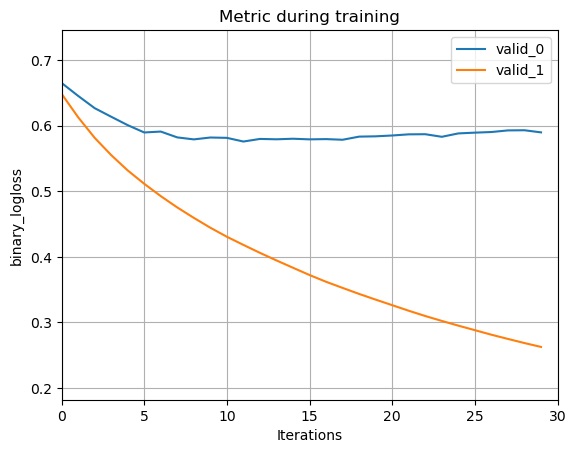

In [29]:
lightgbm.plot_metric(lgb_clf)

In [30]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)
eval_res = {}
#lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=5)
lgb_clf.fit(X_train[:100], y_train[:100], eval_set=[(X_test[:200], y_test[:200]), (X_train[:100], y_train[:100])], verbose=5)

[5]	valid_0's binary_logloss: 0.619972	valid_1's binary_logloss: 0.518128
[10]	valid_0's binary_logloss: 0.601811	valid_1's binary_logloss: 0.407873
[15]	valid_0's binary_logloss: 0.60483	valid_1's binary_logloss: 0.329211
[20]	valid_0's binary_logloss: 0.613627	valid_1's binary_logloss: 0.266267
[25]	valid_0's binary_logloss: 0.629102	valid_1's binary_logloss: 0.223293
[30]	valid_0's binary_logloss: 0.62769	valid_1's binary_logloss: 0.188083


LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)

In [31]:
l_preds = lgb_clf.predict(X_test)

In [32]:
print('accuracy: ', accuracy_score(l_preds, y_test))
print('f1 score: ', f1_score(l_preds, y_test))

accuracy:  0.6810810810810811
f1 score:  0.6579710144927536


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

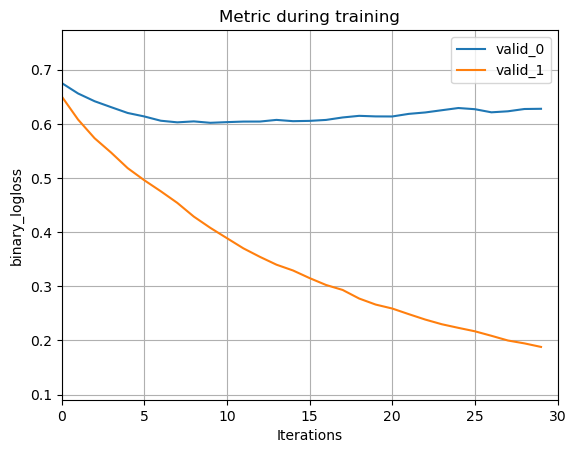

In [33]:
lightgbm.plot_metric(lgb_clf)

In [34]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)
eval_res = {}
#lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=5)
lgb_clf.fit(X_train[:200], y_train[:200], eval_set=[(X_test[:200], y_test[:200]), (X_train[:200], y_train[:200])], verbose=5)

[5]	valid_0's binary_logloss: 0.636151	valid_1's binary_logloss: 0.516151
[10]	valid_0's binary_logloss: 0.608785	valid_1's binary_logloss: 0.400615
[15]	valid_0's binary_logloss: 0.61227	valid_1's binary_logloss: 0.311635
[20]	valid_0's binary_logloss: 0.624508	valid_1's binary_logloss: 0.246723
[25]	valid_0's binary_logloss: 0.628322	valid_1's binary_logloss: 0.197982
[30]	valid_0's binary_logloss: 0.634003	valid_1's binary_logloss: 0.157795


LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)

In [35]:
l_preds = lgb_clf.predict(X_test)

In [36]:
print('accuracy: ', accuracy_score(l_preds, y_test))
print('f1 score: ', f1_score(l_preds, y_test))

accuracy:  0.6932432432432433
f1 score:  0.6780141843971631


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

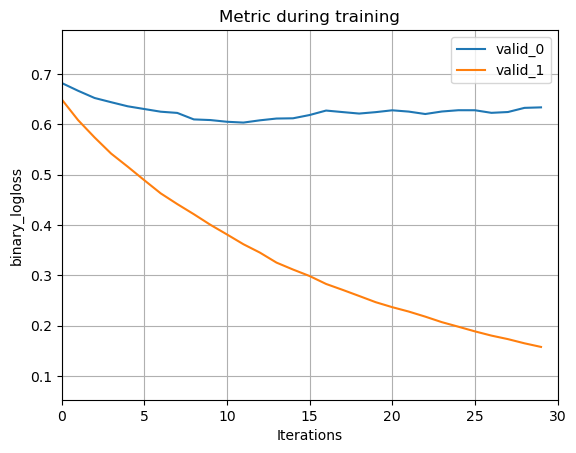

In [37]:
lightgbm.plot_metric(lgb_clf)

In [38]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)
eval_res = {}
#lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=5)
lgb_clf.fit(X_train[:500], y_train[:500], eval_set=[(X_test[:200], y_test[:200]), (X_train[:500], y_train[:500])], verbose=5)

[5]	valid_0's binary_logloss: 0.590589	valid_1's binary_logloss: 0.491087
[10]	valid_0's binary_logloss: 0.528972	valid_1's binary_logloss: 0.369025
[15]	valid_0's binary_logloss: 0.507673	valid_1's binary_logloss: 0.278829
[20]	valid_0's binary_logloss: 0.495658	valid_1's binary_logloss: 0.21431
[25]	valid_0's binary_logloss: 0.497234	valid_1's binary_logloss: 0.16619
[30]	valid_0's binary_logloss: 0.495266	valid_1's binary_logloss: 0.129377


LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)

In [39]:
l_preds = lgb_clf.predict(X_test)

In [40]:
print('accuracy: ', accuracy_score(l_preds, y_test))
print('f1 score: ', f1_score(l_preds, y_test))

accuracy:  0.7391891891891892
f1 score:  0.7071320182094082


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

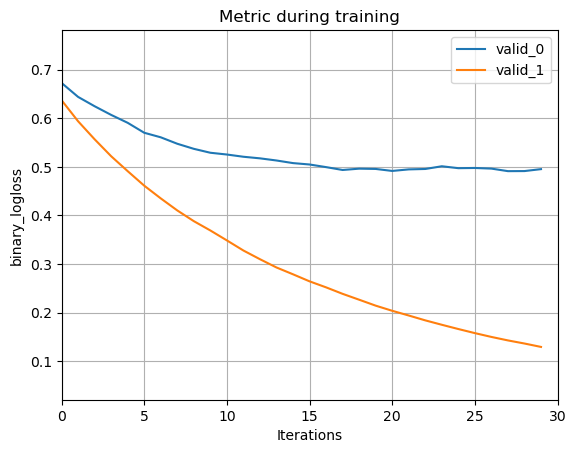

In [41]:
lightgbm.plot_metric(lgb_clf)

In [42]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)
eval_res = {}
#lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=5)
lgb_clf.fit(X_train, y_train, eval_set=[(X_test[:200], y_test[:200]), (X_train, y_train)], verbose=5)

[5]	training's binary_logloss: 0.484435	valid_0's binary_logloss: 0.577613
[10]	training's binary_logloss: 0.356389	valid_0's binary_logloss: 0.526904
[15]	training's binary_logloss: 0.274839	valid_0's binary_logloss: 0.49852
[20]	training's binary_logloss: 0.211646	valid_0's binary_logloss: 0.487322
[25]	training's binary_logloss: 0.163751	valid_0's binary_logloss: 0.485125
[30]	training's binary_logloss: 0.126123	valid_0's binary_logloss: 0.479187


LGBMClassifier(max_depth=10, num_iterations=30, random_state=42)

In [43]:
l_preds = lgb_clf.predict(X_test)

In [44]:
print('accuracy: ', accuracy_score(l_preds, y_test))
print('f1 score: ', f1_score(l_preds, y_test))

accuracy:  0.7594594594594595
f1 score:  0.7420289855072465


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

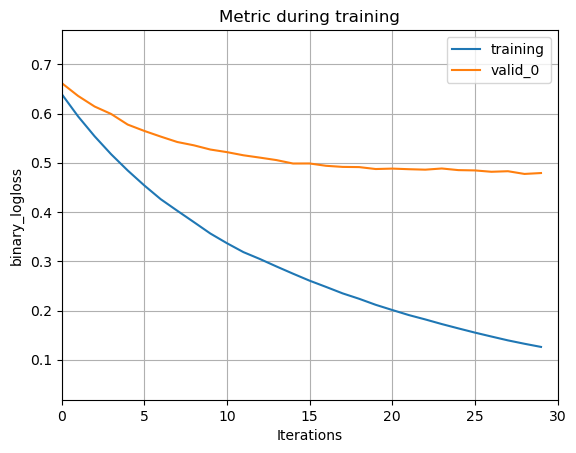

In [45]:
lightgbm.plot_metric(lgb_clf)

In [46]:
'''
def accuracy(pdf):
    cor = 0
    for i in range(len(wv_labels)):
        if pdf[i] == label_df.values[i]:
            cor += 1
    acc = 100*cor/len(pdf)
    return acc

def fscore(pdf):
    cor = 0
    ypnum = 0 #yosoku
    spnum = 0 #seikai
    pnum = 0
    rnum = 0
    fone = 0
    for i in range(len(wv_labels)):
        if pdf[i] == label_df.values[i]:
            cor += 1
        if pdf[i] == 0:
            ypnum += 1
            if label_df.values[i] == 0:
                pnum += 1
        if label_df.values[i] == 0:
            spnum += 1
            if pdf[i] == 0:
                rnum += 1
    # tekigou
    tp = pnum/ypnum
    # saigen
    sp = rnum/spnum
    # f1
    fone = (tp*sp)/(tp+sp)
    return fone
'''

'\ndef accuracy(pdf):\n    cor = 0\n    for i in range(len(wv_labels)):\n        if pdf[i] == label_df.values[i]:\n            cor += 1\n    acc = 100*cor/len(pdf)\n    return acc\n\ndef fscore(pdf):\n    cor = 0\n    ypnum = 0 #yosoku\n    spnum = 0 #seikai\n    pnum = 0\n    rnum = 0\n    fone = 0\n    for i in range(len(wv_labels)):\n        if pdf[i] == label_df.values[i]:\n            cor += 1\n        if pdf[i] == 0:\n            ypnum += 1\n            if label_df.values[i] == 0:\n                pnum += 1\n        if label_df.values[i] == 0:\n            spnum += 1\n            if pdf[i] == 0:\n                rnum += 1\n    # tekigou\n    tp = pnum/ypnum\n    # saigen\n    sp = rnum/spnum\n    # f1\n    fone = (tp*sp)/(tp+sp)\n    return fone\n'